# Report ( City 311 Insight Challenge )


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
train = pd.read_csv("/content/drive/MyDrive/hackerthon_data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/hackerthon_data/test.csv")
train["created_date"] = pd.to_datetime(train["created_date"])
test["created_date"] = pd.to_datetime(test["created_date"])

/tmp/ipython-input-4029940946.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("/content/drive/MyDrive/hackerthon_data/test.csv")


# Making sure training and test sets cover correct time periods.

In [3]:
# drop unfinished dates
# during data retrieval using API from the website, some beginning and ending periods were dropped. So, they were not one full day. The following process makes sure those days are eliminated.
train = train[train["created_date"].dt.date != pd.to_datetime("2024-08-01").date()]
test = test[
    (test["created_date"].dt.date != pd.to_datetime("2025-05-01").date()) &
    (test["created_date"].dt.date != pd.to_datetime("2025-07-31").date())
]

In [4]:
print(train.created_date.min(), train.created_date.max())
print(test.created_date.min(), test.created_date.max())

2024-08-02 00:00:00 2025-04-30 23:59:55
2025-05-02 00:00:03 2025-07-30 23:59:42


# EDA

In [5]:
train.head()

,created_date,closed_date,agency,complaint_type,descriptor,incident_zip,incident_address,street_name,address_type,city,status,resolution_description,borough,open_data_channel_type,latitude,longitude
0,2024-08-06 23:59:58,2024-08-07T17:07:20.000,DPR,Damaged Tree,Entire Tree Has Fallen Down,10468.0,2800 CLAFLIN AVENUE,CLAFLIN AVENUE,ADDRESS,BRONX,Closed,NYC Parks performed the work necessary to corr...,BRONX,PHONE,40.871496,-73.900216
1,2024-08-06 23:59:53,2024-08-19T11:28:34.000,HPD,FLOORING/STAIRS,FLOOR,10001.0,353 WEST 30 STREET,WEST 30 STREET,ADDRESS,NEW YORK,Closed,The Department of Housing Preservation and Dev...,MANHATTAN,PHONE,40.750321,-73.996763
2,2024-08-06 23:59:36,2024-08-07T03:27:32.000,NYPD,Noise - Residential,Banging/Pounding,10469.0,3467 EASTCHESTER ROAD,EASTCHESTER ROAD,ADDRESS,BRONX,Closed,The Police Department responded to the complai...,BRONX,ONLINE,40.878072,-73.846944
3,2024-08-06 23:59:00,2024-09-25T13:55:00.000,DEP,Water System,Hydrant Running (WC3),10469.0,NaN,NaN,INTERSECTION,BRONX,Closed,The Department of Environmental Protection inv...,BRONX,PHONE,40.871818,-73.861364
4,2024-08-06 23:58:54,2024-08-07T00:36:02.000,NYPD,Noise - Residential,Banging/Pounding,11209.0,568 83 STREET,83 STREET,ADDRESS,BROOKLYN,Closed,The Police Department responded to the complai...,BROOKLYN,ONLINE,40.622685,-74.023555


## Visualize the number of call per day for all training dataset


In [6]:
# Extract just the date (drop time)
train['date'] = train['created_date'].dt.date

In [7]:
# Count number of calls per day
daily_calls = train.groupby('date').size().reset_index(name='total_calls')


In [8]:
daily_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         222 non-null    object
 1   total_calls  222 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ KB


In [9]:
daily_calls

,date,total_calls
0,2024-08-02,8230
1,2024-08-03,7426
2,2024-08-04,7719
3,2024-08-05,9611
4,2024-08-06,8507
...,...,...
217,2025-04-26,7895
218,2025-04-27,8085
219,2025-04-28,9265
220,2025-04-29,8891


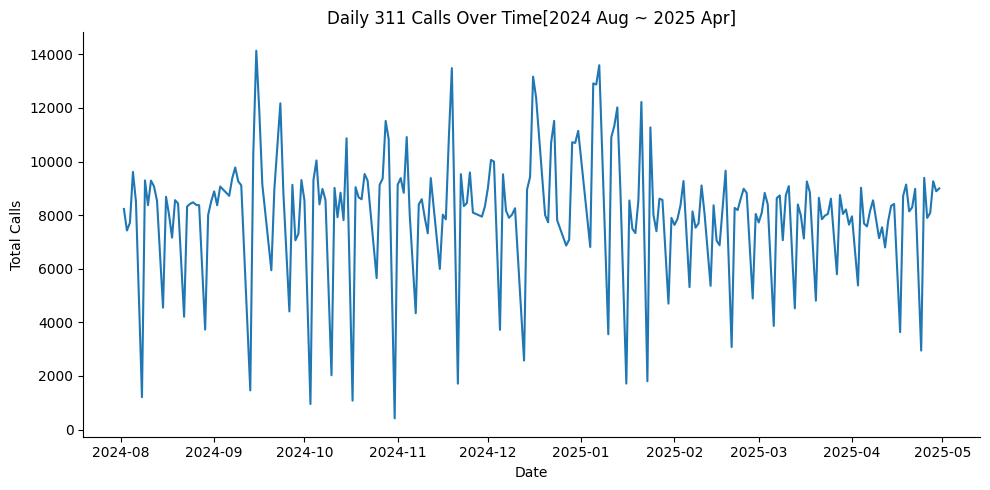

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure data is sorted by date
df_sorted = daily_calls.sort_values('date')

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_sorted, x='date', y='total_calls', color='C0')

plt.xlabel('Date')
plt.ylabel('Total Calls')
plt.title('Daily 311 Calls Over Time[2024 Aug ~ 2025 Apr]')
sns.despine()
plt.tight_layout()
plt.show()


To create a MVP, this first goal is to predict the number of calls per day.

# Forecast future

## To do
1. submission.csv
Required columns (exact order):

 Date,Predicted_Total_Calls
- Date → format YYYY-MM-DD

- Predicted_Total_Calls → integer or float (rounded optional, evaluation can cast to int)

## Must Include
RMSE / MAPE on test set

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


In [12]:
train.head(1)

,created_date,closed_date,agency,complaint_type,descriptor,incident_zip,incident_address,street_name,address_type,city,status,resolution_description,borough,open_data_channel_type,latitude,longitude,date
0,2024-08-06 23:59:58,2024-08-07T17:07:20.000,DPR,Damaged Tree,Entire Tree Has Fallen Down,10468.0,2800 CLAFLIN AVENUE,CLAFLIN AVENUE,ADDRESS,BRONX,Closed,NYC Parks performed the work necessary to corr...,BRONX,PHONE,40.871496,-73.900216,2024-08-06


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1803444 entries, 0 to 1807229
Data columns (total 17 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   created_date            datetime64[ns]
 1   closed_date             object        
 2   agency                  object        
 3   complaint_type          object        
 4   descriptor              object        
 5   incident_zip            float64       
 6   incident_address        object        
 7   street_name             object        
 8   address_type            object        
 9   city                    object        
 10  status                  object        
 11  resolution_description  object        
 12  borough                 object        
 13  open_data_channel_type  object        
 14  latitude                float64       
 15  longitude               float64       
 16  date                    object        
dtypes: datetime64[ns](1), float64(3), object(13)
memory

In [14]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=daily_calls.index.min(), end=daily_calls.index.max())

In [15]:
def make_features(df):
    """Produce time-series features from time series index"""
    # some features are commented out because they are proved to be nonbenefit to the model training ( from feature importance calculation, which will be discussed after model training.)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    #df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    #df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

    df['month'] = df.index.month
    #df['is_holiday'] = df.index.isin(holidays).astype(int)
    df['lag_1'] = df['total_calls'].shift(1) # calculate total calls from yesterday
    df['lag_7'] = df['total_calls'].shift(7) # calculate total calls form last week
    df['rolling_mean_7'] = df['total_calls'].shift(1).rolling(7).mean()
    df['rolling_std_7'] = df['total_calls'].shift(1).rolling(7).std()

    df.dropna(inplace=True)
    return df

In [16]:
daily_calls = make_features(daily_calls)
daily_calls.head(3)

,total_calls,dayofweek,quarter,month,dayofyear,lag_1,lag_7,rolling_mean_7,rolling_std_7
date,,,,,,,,,
2024-08-10,8371,5,3,8,223,9295.0,8230.0,7428.000000,2852.826318
2024-08-11,9287,6,3,8,224,8371.0,7426.0,7448.142857,2859.921702
2024-08-12,9073,0,3,8,225,9287.0,7719.0,7714.000000,2942.817754


## Look for seasonal patterns


In [17]:
X = daily_calls.copy()
X["day"] = X.index.dayofweek         # 0=Monday, 6=Sunday
X["week"] = X.index.isocalendar().week
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
X["total_calls"] = X["total_calls"]


In [18]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

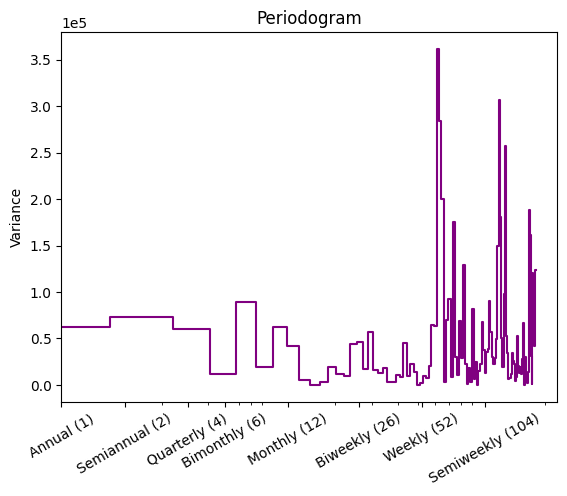

In [19]:
plot_periodogram(daily_calls.total_calls);

The number of calls follows a similar pattern every week as described by the spike in weekly column. So, to follow up this discovery, we will be formulating a seasonal plot.

In [20]:
# Looking for seasonal patterns
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


/tmp/ipython-input-3339791328.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
/tmp/ipython-input-3339791328.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


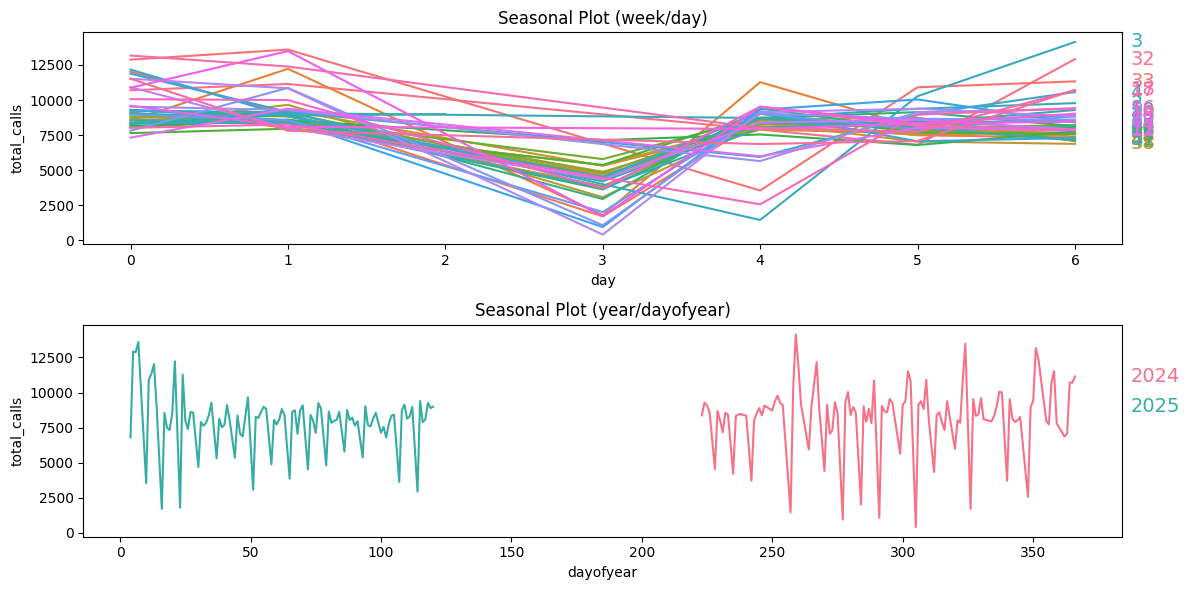

In [21]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

seasonal_plot(X, y="total_calls", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="total_calls", period="year", freq="dayofyear", ax=ax1)

plt.tight_layout()
plt.show()


- The week/day seasonal plot shows that Wednesday (day=3) consistently has the lowest calls, and there's a clear dip mid-week that recovers by weekend.
- That confirms what the periodogram told: a strong weekly cycle

## Prep the test set

In [22]:
# repeat the same processes for test set
test['date'] = test['created_date'].dt.date
# Count number of calls per day
daily_calls_test = test.groupby('date').size().reset_index(name='total_calls')

daily_calls_test = make_features(daily_calls_test)
daily_calls_test.head(3)


,total_calls,dayofweek,quarter,month,dayofyear,lag_1,lag_7,rolling_mean_7,rolling_std_7
date,,,,,,,,,
2025-05-10,9655,5,2,5,130,7761.0,9596.0,7415.428571,2806.288822
2025-05-11,10175,6,2,5,131,9655.0,9070.0,7423.857143,2814.007607
2025-05-12,9739,0,2,5,132,10175.0,7984.0,7581.714286,2949.474570


In [23]:
X_train = daily_calls.drop('total_calls', axis=1)
y_train = daily_calls['total_calls']
X_test = daily_calls_test.drop('total_calls', axis=1)
y_test = daily_calls_test['total_calls']

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

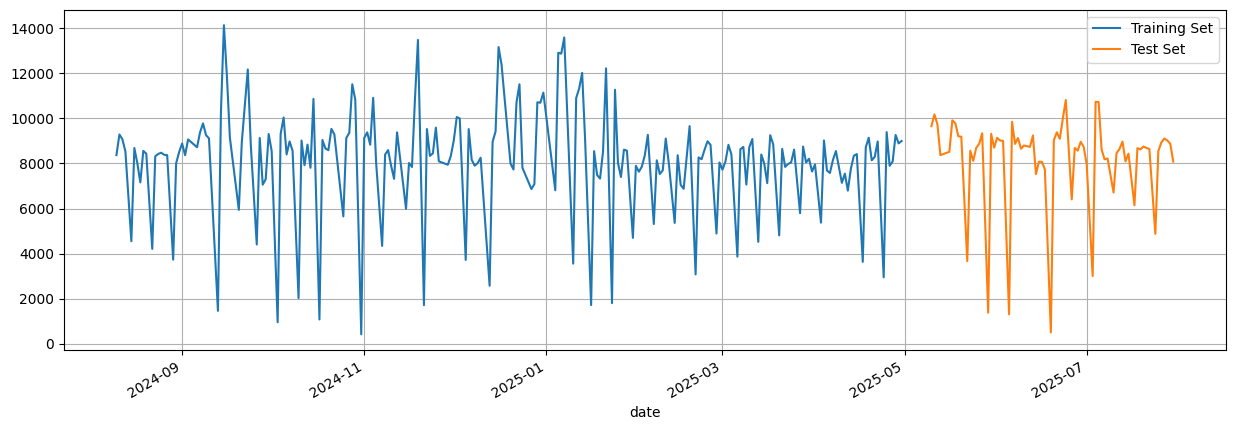

In [25]:
fig, ax = plt.subplots(figsize = (15,5))

daily_calls.plot(ax = ax, label= "Training Set", y = 'total_calls')
daily_calls_test.plot(ax= ax, label = "Test Set", y = 'total_calls')
plt.legend()
plt.grid(True)
plt.show()

Below 2000 calls/day and above 12000 calls/per day can be discarded as outliers to lower noise.

In [26]:
daily_calls.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2024-08-10 to 2025-04-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_calls     215 non-null    int64  
 1   dayofweek       215 non-null    int32  
 2   quarter         215 non-null    int32  
 3   month           215 non-null    int32  
 4   dayofyear       215 non-null    int32  
 5   lag_1           215 non-null    float64
 6   lag_7           215 non-null    float64
 7   rolling_mean_7  215 non-null    float64
 8   rolling_std_7   215 non-null    float64
dtypes: float64(4), int32(4), int64(1)
memory usage: 13.4 KB


<Axes: xlabel='date'>

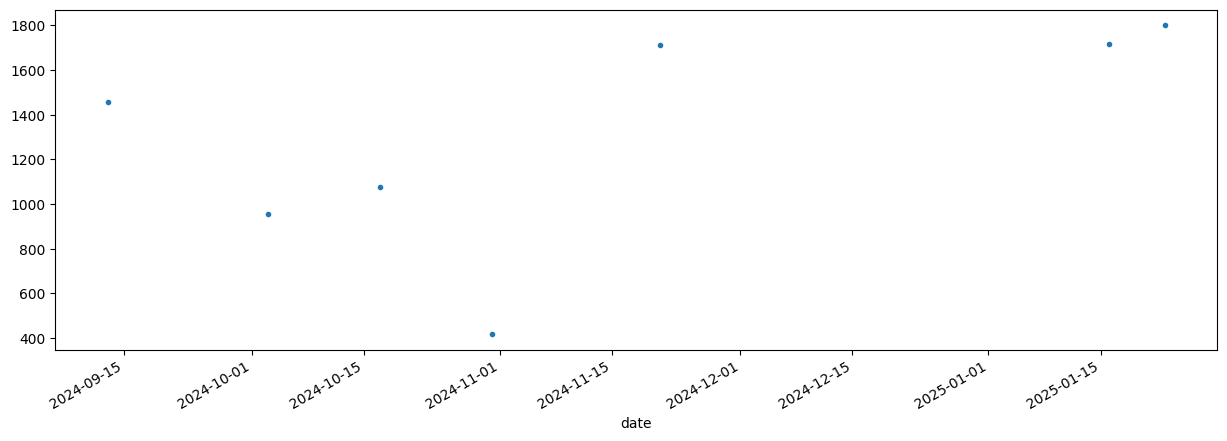

In [27]:
daily_calls.query("total_calls < 2000")["total_calls"].plot(figsize = (15,5),style=".")

<Axes: xlabel='date'>

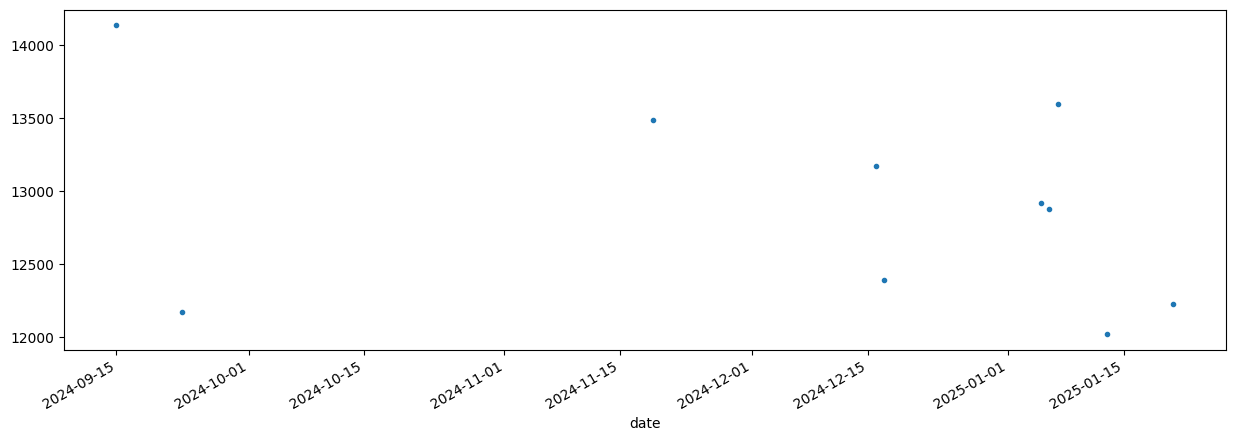

In [28]:
daily_calls.query("total_calls > 12000")["total_calls"].plot(figsize = (15,5),style=".")

## Model Training

In [29]:
daily_calls.total_calls.describe()

,total_calls
count,215.000000
mean,8146.269767
std,2321.010753
min,417.000000
25%,7710.000000
50%,8400.000000
75%,9122.000000
max,14135.000000


In [30]:
X_train.describe()

,dayofweek,quarter,month,dayofyear,lag_1,lag_7,rolling_mean_7,rolling_std_7
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,3.136646,2.608696,6.838509,193.975155,8237.708075,8069.596273,8149.403727,2245.609216
std,2.200843,1.250869,3.949526,120.593426,2295.995518,2404.155601,807.800717,947.984471
min,0.000000,1.000000,1.000000,5.000000,1077.000000,417.000000,6793.571429,455.749513
25%,1.000000,1.000000,3.000000,75.000000,7726.000000,7644.000000,7678.000000,1511.244268
50%,4.000000,3.000000,8.000000,237.000000,8398.000000,8396.000000,7881.142857,2112.917786
75%,5.000000,4.000000,10.000000,302.000000,9271.000000,9132.000000,8496.142857,3087.691586
max,6.000000,4.000000,12.000000,366.000000,14135.000000,14135.000000,11027.571429,4507.410190


Before outlier removal : Variance of total_calls from 417 to 14,000 is a huge spread.


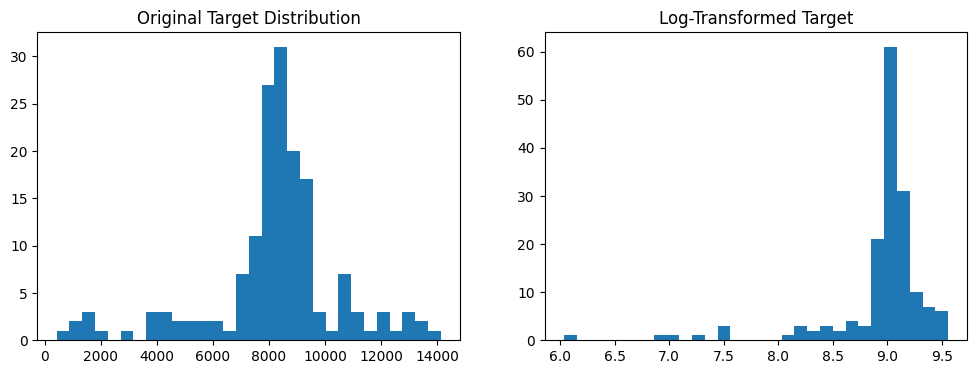

In [31]:
# Could this data be skewed? Could this be improved with log transformation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30)
plt.title("Original Target Distribution")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(y_train), bins=30)
plt.title("Log-Transformed Target")
plt.show()
# no. so won't be doing log-transformation

In [32]:
# winsorizing
from scipy.stats.mstats import winsorize

# Example: cap the lowest 1% and highest 1%
y_train_winsor = winsorize(y_train, limits=[0.01, 0.01])


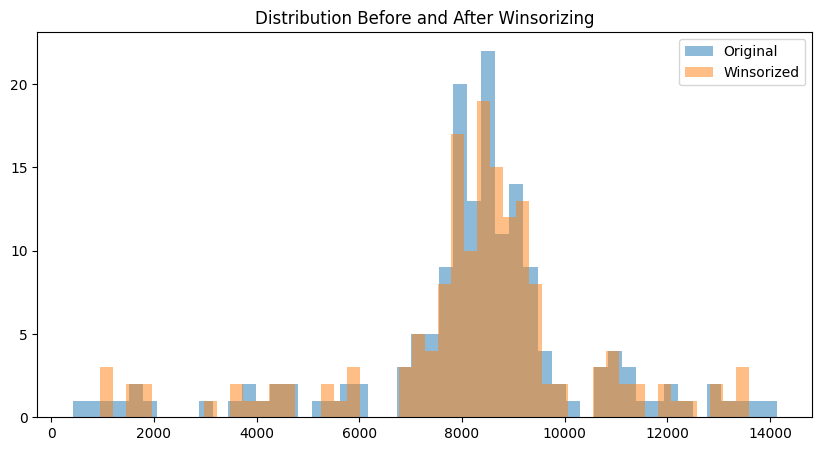

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=50, alpha=0.5, label="Original")
plt.hist(y_train_winsor, bins=50, alpha=0.5, label="Winsorized")
plt.legend()
plt.title("Distribution Before and After Winsorizing")
plt.show()


In [34]:
# default
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize model
model = XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.05, early_stopping_rounds=50, random_state = 7)


# Fit model with early stopping and eval_set
model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid), ( X_test, y_test)],
    verbose=True
)

# Predict
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-9))) * 100



# Print results
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape, 2), "%")




[0]	validation_0-rmse:2095.97761	validation_1-rmse:1936.66550
[1]	validation_0-rmse:2038.13347	validation_1-rmse:1868.87990
[2]	validation_0-rmse:1985.10974	validation_1-rmse:1806.84762
[3]	validation_0-rmse:1936.08152	validation_1-rmse:1749.30101
[4]	validation_0-rmse:1886.86396	validation_1-rmse:1702.70633
[5]	validation_0-rmse:1845.38133	validation_1-rmse:1659.78892
[6]	validation_0-rmse:1808.77707	validation_1-rmse:1620.23762
[7]	validation_0-rmse:1780.67545	validation_1-rmse:1582.40825
[8]	validation_0-rmse:1753.45254	validation_1-rmse:1550.57022
[9]	validation_0-rmse:1726.73825	validation_1-rmse:1523.25379
[10]	validation_0-rmse:1713.53820	validation_1-rmse:1499.22964
[11]	validation_0-rmse:1697.00335	validation_1-rmse:1471.80134
[12]	validation_0-rmse:1679.05547	validation_1-rmse:1452.53586
[13]	validation_0-rmse:1661.94010	validation_1-rmse:1434.09645
[14]	validation_0-rmse:1649.57322	validation_1-rmse:1413.55692
[15]	validation_0-rmse:1641.10590	validation_1-rmse:1396.87888
[1

In [35]:
# winsorized data
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize model
model = XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.05, early_stopping_rounds=50, random_state = 7)


# Fit model with early stopping and eval_set
model.fit(
    X_train,
    y_train_winsor,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

# Predict
y_pred_winsor = model.predict(X_test)

# Metrics
mae_winsor = mean_absolute_error(y_test, y_pred_winsor)
rmse_winsor = np.sqrt(mean_squared_error(y_test, y_pred_winsor))

mape_winsor = np.mean(np.abs((y_test - y_pred_winsor) / np.clip(np.abs(y_test), 100, None))) * 100


# Print results
print("MAE:", round(mae_winsor, 2))
print("RMSE:", round(rmse_winsor, 2))
print("MAPE:", round(mape_winsor, 2), "%")



MAE: 1027.99
RMSE: 1393.68
MAPE: 29.72 %


# b4 handling outliers :



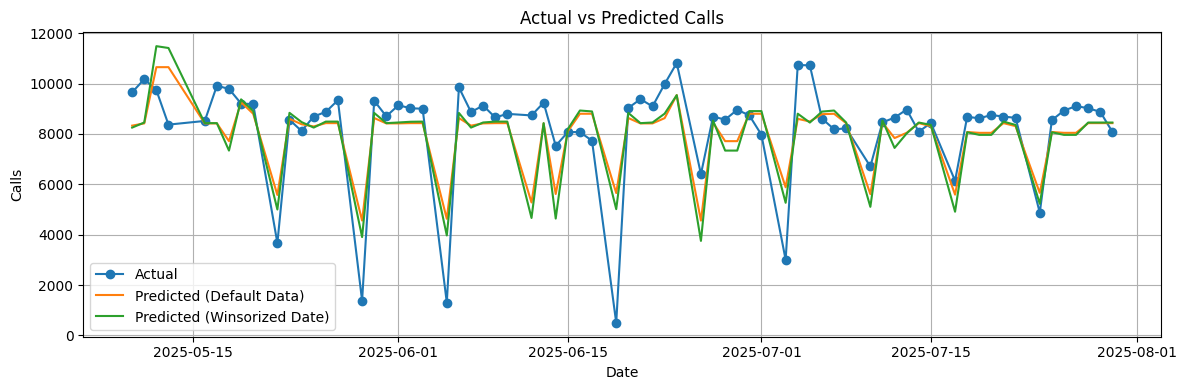

In [36]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test, label="Actual", marker='o')
plt.plot(y_test.index, y_pred, label="Predicted (Default Data)")
plt.plot(y_test.index, y_pred_winsor, label="Predicted (Winsorized Date)")
#plt.plot(y_test.index, y_pred_boxcox, label="Predicted (BoxCox Data)") # give very terrible results
plt.legend()
plt.title("Actual vs Predicted Calls")
plt.xlabel("Date")
plt.ylabel("Calls")
plt.grid(True)
plt.tight_layout()
plt.show()



# Finding the most appropriate time-series features.

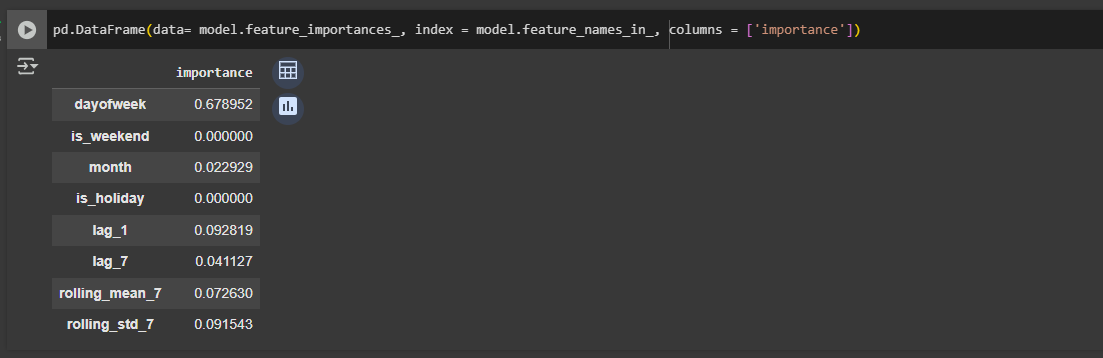

- is_weekend and is_holiday will be dropped.

---------------- after adding new features ------------------

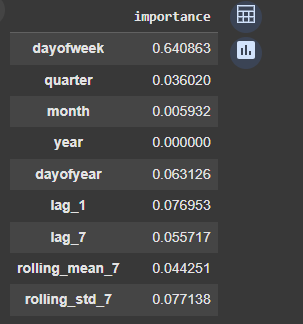

MAE: 976.1
RMSE: 1304.39
MAPE: 27.7 % (without outliers) , 27.89% with outliers


- with holiday features -------------


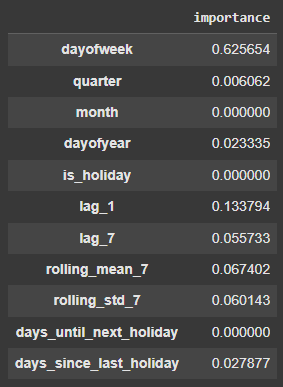
MAE: 1173.88
RMSE: 1621.4
MAPE: 34.77 %

In [37]:
pd.DataFrame(data= model.feature_importances_, index = model.feature_names_in_, columns = ['importance'])

,importance
dayofweek,0.643894
quarter,0.018010
month,0.011295
dayofyear,0.061314
lag_1,0.086073
lag_7,0.053588
rolling_mean_7,0.057510
rolling_std_7,0.068317


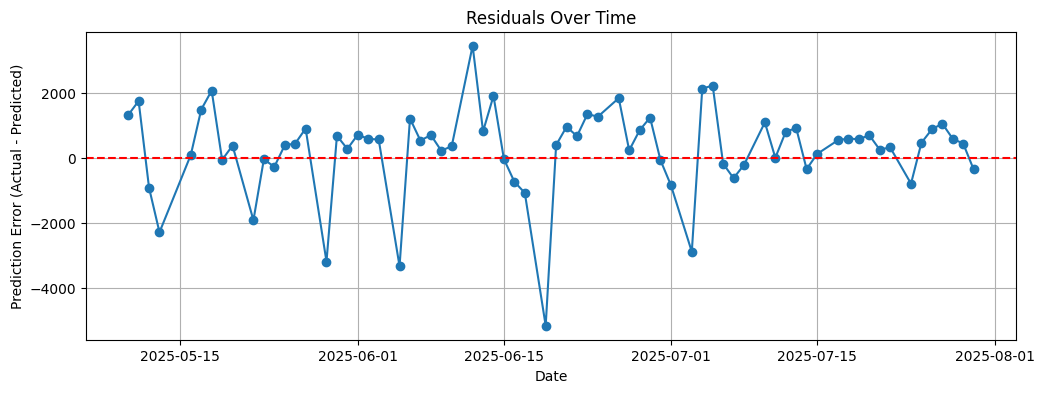

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
# visualize how wrong the model's predicitons are
residuals = y_test - y_pred
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, residuals, marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Prediction Error (Actual - Predicted)")
plt.grid(True)
plt.show()


In [39]:


# Get top 5 indexes with max absolute errors
top5_error_indexes = residuals.abs().nlargest(5).index

print("Top 5 dates with highest prediction errors: [WORST PREDICTIONS]")
print(top5_error_indexes)


Top 5 dates with highest prediction errors:
DatetimeIndex(['2025-06-19', '2025-06-12', '2025-06-05', '2025-05-29',
               '2025-07-03'],
              dtype='datetime64[ns]', name='date', freq=None)


In [40]:
# Show both index and error value
top5_errors = residuals.loc[top5_error_indexes]
print(top5_errors)


date
2025-06-19   -5154.564941
2025-06-12    3455.302734
2025-06-05   -3325.263672
2025-05-29   -3182.818848
2025-07-03   -2880.288574
Name: total_calls, dtype: float64


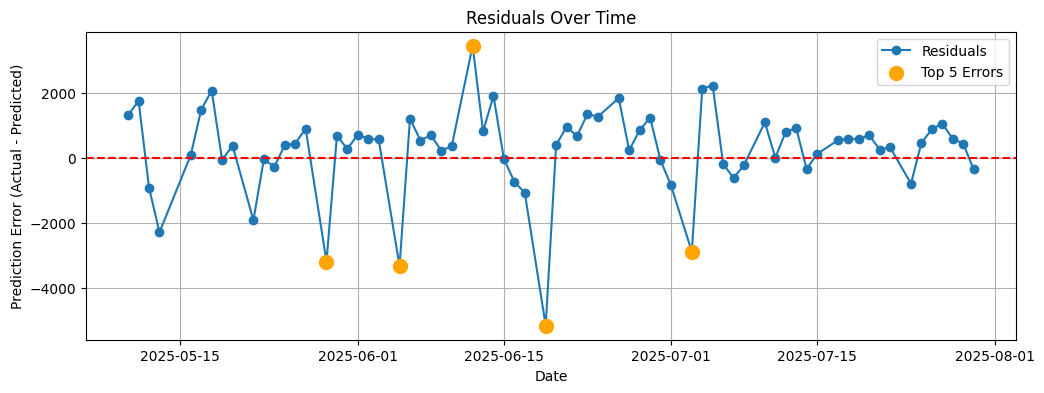

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, residuals, marker='o', linestyle='-', label='Residuals')
plt.axhline(0, color='red', linestyle='--')

# Highlight top 5 errors
plt.scatter(top5_error_indexes, residuals.loc[top5_error_indexes],
            color='orange', s=100, zorder=5, label='Top 5 Errors')

plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Prediction Error (Actual - Predicted)")
plt.grid(True)
plt.legend()
plt.show()


## Prep submission

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2025-04-11 to 2024-11-15
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dayofweek       161 non-null    int32  
 1   quarter         161 non-null    int32  
 2   month           161 non-null    int32  
 3   dayofyear       161 non-null    int32  
 4   lag_1           161 non-null    float64
 5   lag_7           161 non-null    float64
 6   rolling_mean_7  161 non-null    float64
 7   rolling_std_7   161 non-null    float64
dtypes: float64(4), int32(4)
memory usage: 8.8 KB


# Anomaly Detection

Date,Actual,Expected,Anomaly_Score,Note

○	Date → format YYYY-MM-DD

○	Actual → actual observed calls (integer)

○	Expected → model’s expected calls (float)

○	Anomaly_Score → difference or % deviation (document your method in README)

○	Note → optional brief reason (e.g. Snowstorm, Holiday)
* Usual days should get ~90% accuracy


In [43]:
X_train.head()

,dayofweek,quarter,month,dayofyear,lag_1,lag_7,rolling_mean_7,rolling_std_7
date,,,,,,,,
2025-04-11,4,2,4,101,7140.0,5375.0,7643.857143,1182.552526
2025-01-23,3,1,1,23,12223.0,9017.0,7837.428571,3148.715815
2025-03-27,3,1,3,86,8615.0,8850.0,7827.714286,1386.003934
2024-11-11,0,4,11,316,7905.0,8832.0,8141.571429,1955.891174
2025-03-16,6,1,3,75,7989.0,8734.0,7788.857143,1585.082903


In [44]:
month_deviations = daily_calls.groupby(lambda d: d.month).std()
month_deviations

,total_calls,dayofweek,quarter,month,dayofyear,lag_1,lag_7,rolling_mean_7,rolling_std_7
date,,,,,,,,,
1,3366.630254,2.208500,0.0,0.0,8.270620,3404.936113,3379.234454,1241.371412,619.401743
2,1557.159864,2.160247,0.0,0.0,8.281287,1555.797992,1707.934253,259.891350,417.391549
3,1414.363570,2.224571,0.0,0.0,9.269163,1415.131226,1495.492293,230.255063,282.856004
4,1588.024395,2.125667,0.0,0.0,8.856549,1569.151822,1232.653104,231.858209,622.473882
8,1653.343175,2.156182,0.0,0.0,6.610730,1683.215415,2107.845605,304.014896,628.528382
9,2555.023621,2.386557,0.0,0.0,9.181525,2553.707945,2466.038522,736.449691,1172.207419
10,3176.165716,2.158703,0.0,0.0,8.952281,2792.469315,2813.871229,614.507829,663.236819
11,2216.186781,2.196423,0.0,0.0,8.921457,2744.886091,2934.300047,429.057237,1002.990827
12,2428.785272,2.375906,0.0,0.0,9.556753,2382.914690,2192.450432,817.105698,799.398084


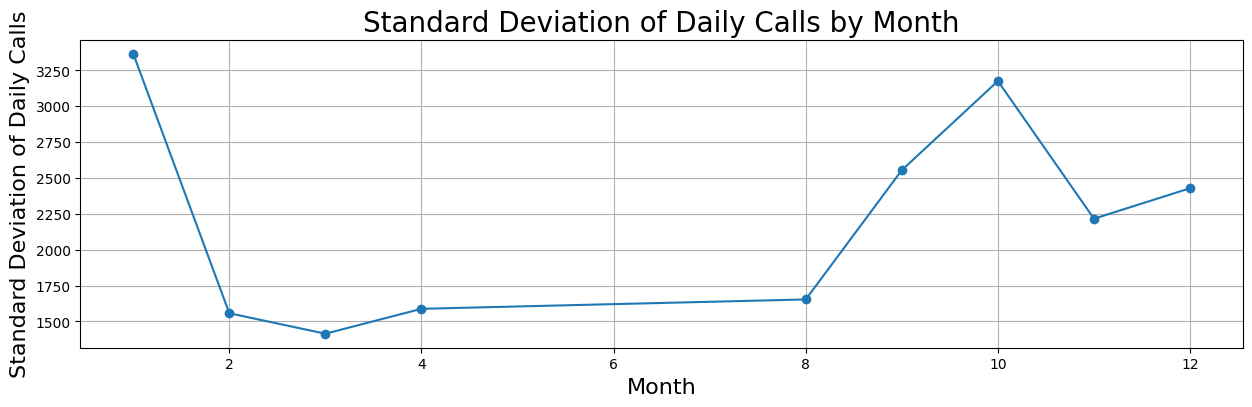

In [45]:
# show how much daily call volume fluctuates within each month
# Calculate standard deviation of daily calls per month
# Spikes shouw abrupt ups and downs in daiy call count throughout the month.
month_std = daily_calls.groupby(daily_calls.index.month)['total_calls'].std()

# Plot
plt.figure(figsize=(15, 4))
plt.plot(month_std.index, month_std.values, marker='o')
plt.title('Standard Deviation of Daily Calls by Month', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Standard Deviation of Daily Calls', fontsize=16)
plt.grid(True)
plt.show()


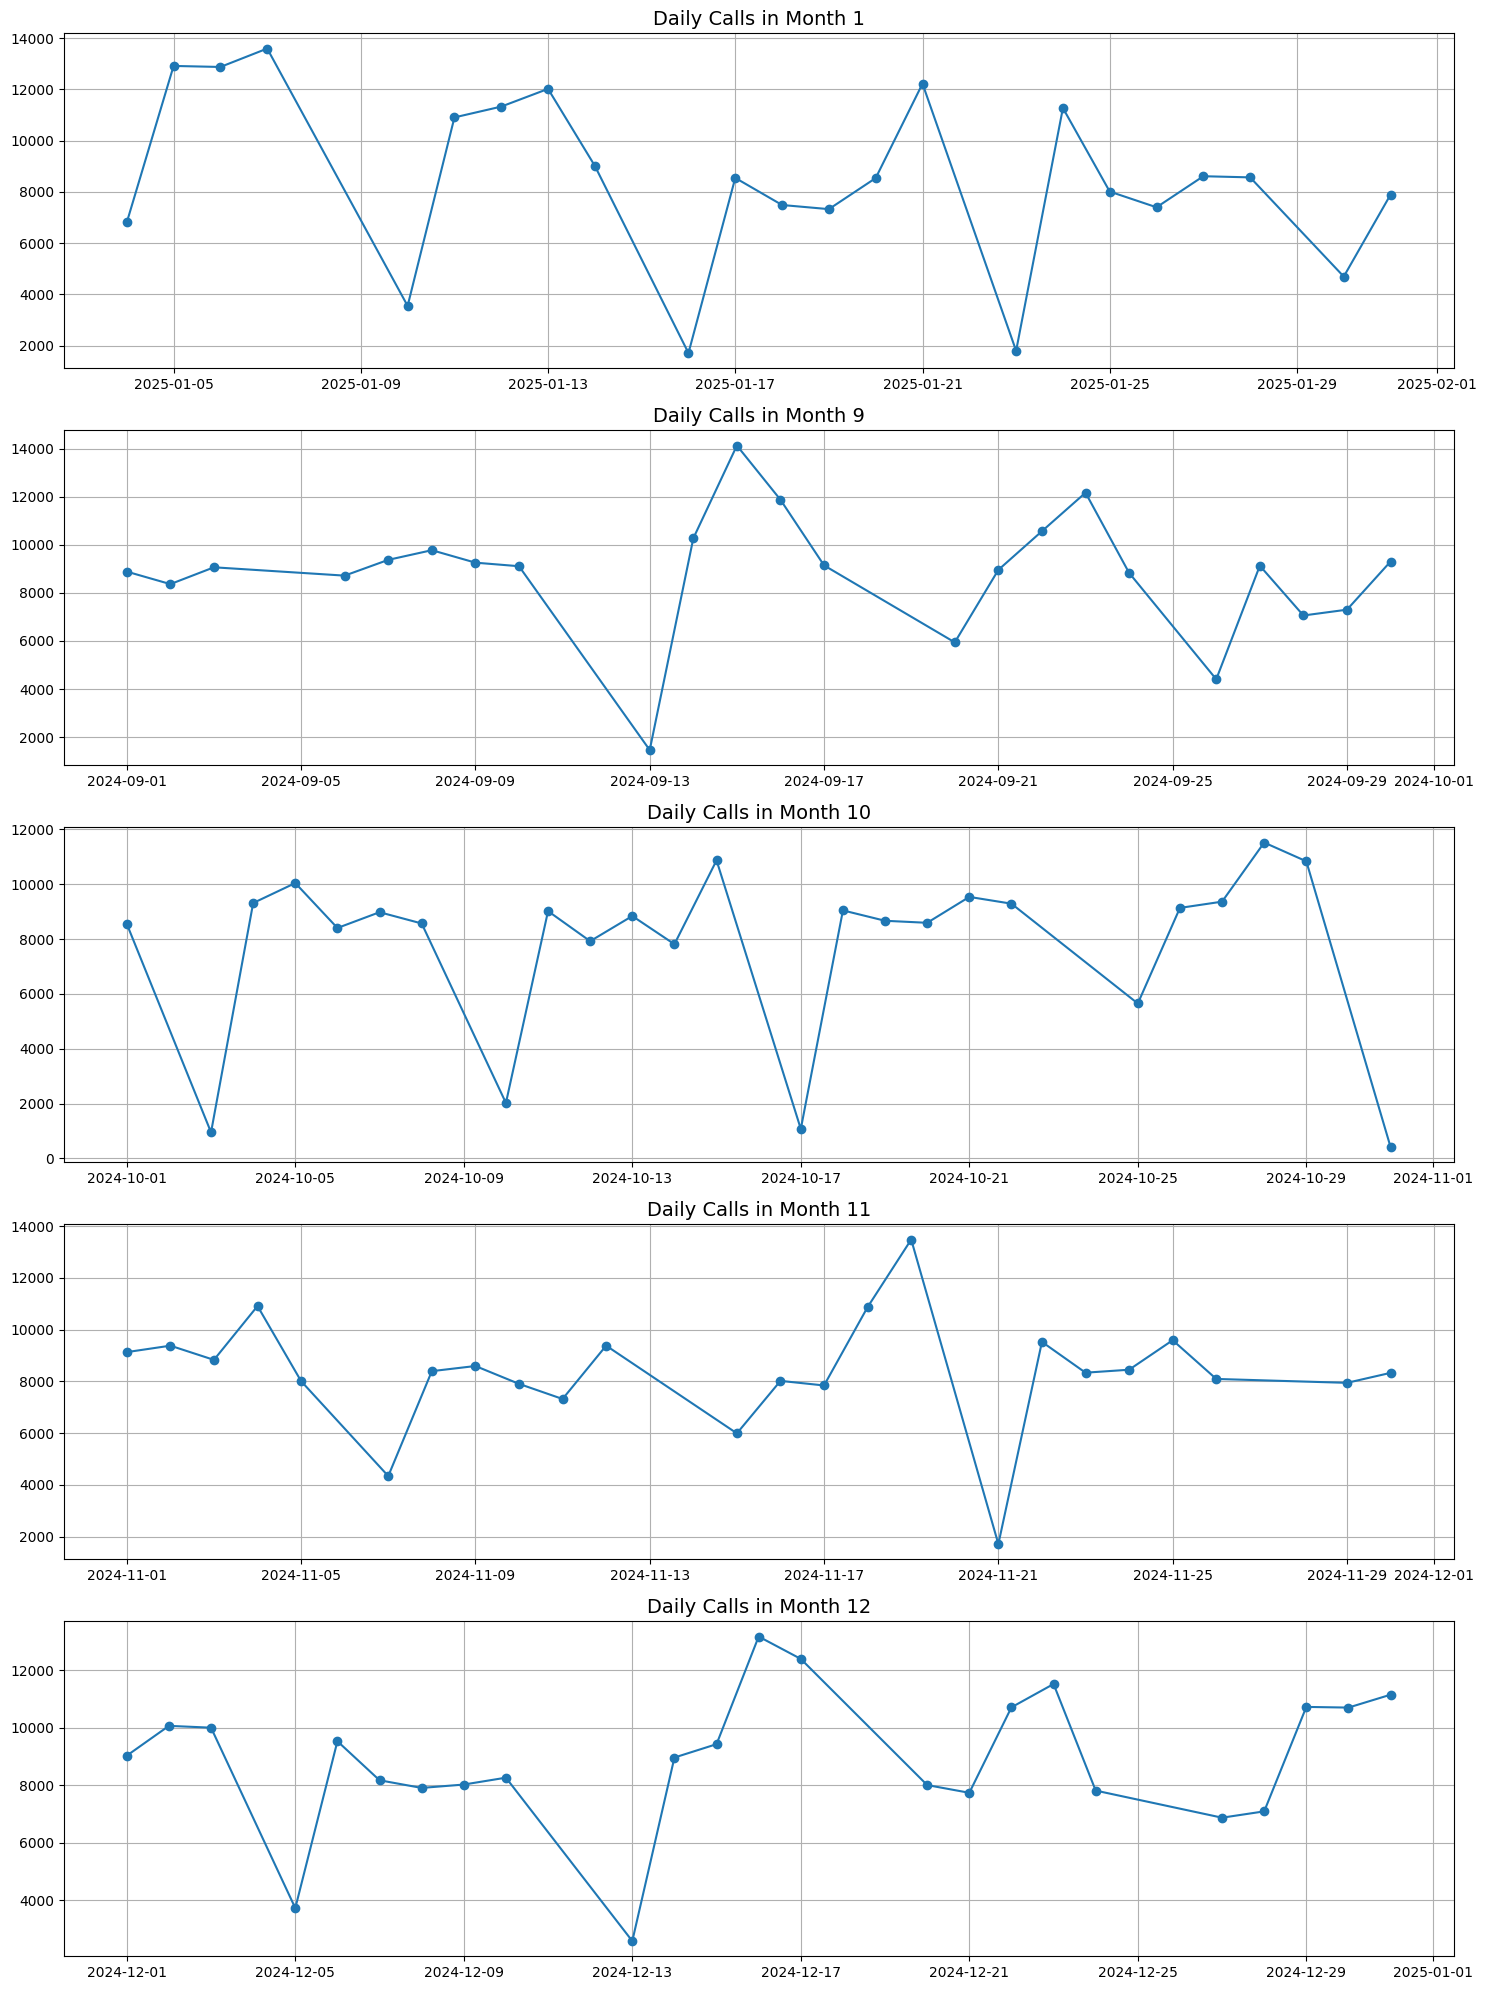

In [46]:
# Looking into the months with spikes
import matplotlib.pyplot as plt

abnormal_mth = [1, 9, 10, 11, 12]
fig, axs = plt.subplots(len(abnormal_mth), 1, figsize=(15, 20), sharex=False)

for i, month in enumerate(abnormal_mth):
    data = daily_calls[daily_calls.index.month == month]
    axs[i].plot(data.index, data['total_calls'], marker='o')
    axs[i].set_title(f'Daily Calls in Month {month}', fontsize=14)
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [47]:
# filtering the 2% extremeties from the training sets
mths = list(range(1, 13))

# Filter by months
abnormal_days = daily_calls[daily_calls.index.month.isin(mths)]

# Define high and low thresholds
upper_threshold = abnormal_days['total_calls'].quantile(0.98)
lower_threshold = abnormal_days['total_calls'].quantile(0.03)

# Get high and low extreme days
high_abnormal_days = abnormal_days[abnormal_days['total_calls'] > upper_threshold]
low_abnormal_days = abnormal_days[abnormal_days['total_calls'] < lower_threshold]

# Sort high abnormal days (most calls first)
high_abnormal_days_sorted = high_abnormal_days.sort_values(by='total_calls', ascending=False)

# Sort low abnormal days (least calls first)
low_abnormal_days_sorted = low_abnormal_days.sort_values(by='total_calls', ascending=True)

# Print results
print("🔺 High Abnormal Days - above 98% (Most Calls First):")
print(high_abnormal_days_sorted.total_calls)

print("\n🔻 Low Abnormal Days - below 3% (Least Calls First):")
print(low_abnormal_days_sorted.total_calls.head)



🔺 High Abnormal Days - above 98% (Most Calls First):
date
2024-09-15    14135
2025-01-07    13593
2024-11-19    13484
2024-12-16    13167
2025-01-05    12915
Name: total_calls, dtype: int64

🔻 Low Abnormal Days - below 3% (Least Calls First):
<bound method NDFrame.head of date
2024-10-31     417
2024-10-03     953
2024-10-17    1077
2024-09-13    1459
2024-11-21    1711
2025-01-16    1715
2025-01-23    1802
Name: total_calls, dtype: int64>


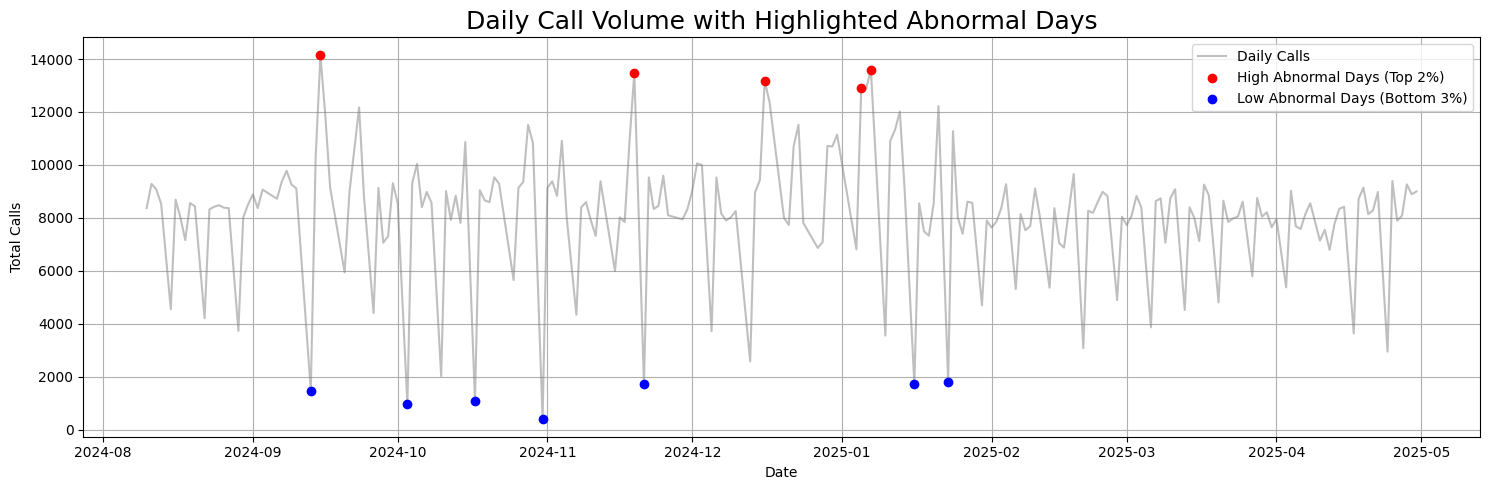

In [48]:
import matplotlib.pyplot as plt

# Full time series
plt.figure(figsize=(15, 5))
plt.plot(daily_calls.index, daily_calls['total_calls'], label='Daily Calls', color='gray', alpha=0.5)

# Overlay high abnormal days (🔺)
plt.scatter(high_abnormal_days_sorted.index,
            high_abnormal_days_sorted['total_calls'],
            color='red', label='High Abnormal Days (Top 2%)', zorder=5)

# Overlay low abnormal days (🔻)
plt.scatter(low_abnormal_days_sorted.index,
            low_abnormal_days_sorted['total_calls'],
            color='blue', label='Low Abnormal Days (Bottom 3%)', zorder=5)

# Styling
plt.title('Daily Call Volume with Highlighted Abnormal Days', fontsize=18)
plt.xlabel('Date')
plt.ylabel('Total Calls')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
# removing anomalies from the training set
# the upper and lower limits are taken from anomaly detection results

normal_mths = [m for m in range(1, 13) if m not in abnormal_mth]
# Extract normal-month days
is_normal_month = daily_calls.index.month.isin(normal_mths)

# Compute rolling mean **only over normal months**
rolling_mean_normal = daily_calls['total_calls'][is_normal_month].rolling(
    window=7, center=True, min_periods=1
).mean()

# Reindex to match full index
rolling_mean_aligned = rolling_mean_normal.reindex(daily_calls.index)

# 5. Detect abnormal days (e.g., top/bottom 5%)
upper_threshold = daily_calls['total_calls'].quantile(0.95)
lower_threshold = daily_calls['total_calls'].quantile(0.05)
is_abnormal = (daily_calls['total_calls'] > upper_threshold) | (daily_calls['total_calls'] < lower_threshold)

# 6. Replace abnormal values using rolling mean from normal months only
daily_calls['total_calls'] = daily_calls['total_calls'].where(~is_abnormal, rolling_mean_aligned)

In [50]:
print(f"Abnormal values replaced: {is_abnormal.sum()}")


Abnormal values replaced: 22


In [51]:
X_train = daily_calls.drop('total_calls', axis=1)
y_train = daily_calls['total_calls']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

In [52]:
# default
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Drop rows with NaN values from training and validation sets
train_data = pd.concat([X_train, y_train], axis=1).dropna()
X_train = train_data.drop('total_calls', axis=1)
y_train = train_data['total_calls']

valid_data = pd.concat([X_valid, y_valid], axis=1).dropna()
X_valid = valid_data.drop('total_calls', axis=1)
y_valid = valid_data['total_calls']

# Initialize model
model = XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.05, early_stopping_rounds=50, random_state = 7)


# Fit model with early stopping and eval_set
model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid), ( X_test, y_test)],
    verbose=True
)

# Predict
y_pred = model.predict(X_test)

# Metrics
mae_modified = mean_absolute_error(y_test, y_pred)
rmse_modified = np.sqrt(mean_squared_error(y_test, y_pred))

mape_modified = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-9))) * 100


# Print results
print("MAE:", round(mae_modified, 2))
print("RMSE:", round(rmse_modified, 2))
print("MAPE:", round(mape_modified, 2), "%")
model.save_model("xgboost_model.json")

[0]	validation_0-rmse:1592.20267	validation_1-rmse:1957.71958
[1]	validation_0-rmse:1552.47165	validation_1-rmse:1912.98062
[2]	validation_0-rmse:1521.90475	validation_1-rmse:1871.23013
[3]	validation_0-rmse:1493.62645	validation_1-rmse:1830.66478
[4]	validation_0-rmse:1467.30620	validation_1-rmse:1791.32435
[5]	validation_0-rmse:1445.80835	validation_1-rmse:1756.31999
[6]	validation_0-rmse:1426.73019	validation_1-rmse:1724.11814
[7]	validation_0-rmse:1409.87373	validation_1-rmse:1691.73920
[8]	validation_0-rmse:1387.93324	validation_1-rmse:1662.51915
[9]	validation_0-rmse:1370.09260	validation_1-rmse:1633.18425
[10]	validation_0-rmse:1356.23647	validation_1-rmse:1607.41050
[11]	validation_0-rmse:1341.72176	validation_1-rmse:1583.20196
[12]	validation_0-rmse:1331.47448	validation_1-rmse:1559.04918
[13]	validation_0-rmse:1320.29638	validation_1-rmse:1542.85595
[14]	validation_0-rmse:1312.10444	validation_1-rmse:1524.07324
[15]	validation_0-rmse:1306.64353	validation_1-rmse:1504.19331
[1

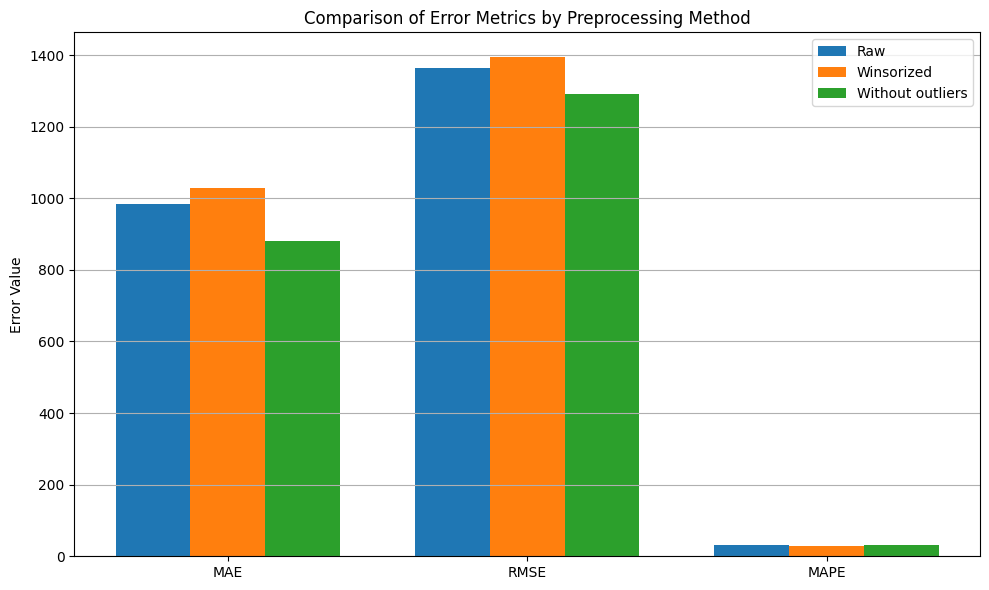

In [53]:
# compare default model, winsorized data and data without outliers
# all parameters are identical.
metrics = ['MAE', 'RMSE', 'MAPE']

raw = [mae, rmse, mape]
winsor = [mae_winsor, rmse_winsor, mape_winsor]
modified = [mae_modified, rmse_modified, mape_modified]

x = np.arange(len(metrics))
width = 0.25

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width, raw, width, label='Raw')
plt.bar(x, winsor, width, label='Winsorized')
plt.bar(x + width, modified, width, label='Without outliers')

# Labels and formatting
plt.ylabel('Error Value')
plt.title('Comparison of Error Metrics by Preprocessing Method')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [54]:
# Predict
y_pred = model.predict(X_test)

# Round predictions if desired
y_pred_rounded = np.round(y_pred).astype(int)

# Create submission DataFrame
submission = pd.DataFrame({
    'Date': X_test.index.strftime('%Y-%m-%d'),  # format index as string YYYY-MM-DD
    'Predicted_Total_Calls': y_pred_rounded
})

# Save CSV
submission.to_csv('submission.csv', index=False)


In [55]:
y_pred

array([8767.265 , 8950.282 , 9219.432 , 8883.463 , 8294.323 , 8901.036 ,
       7660.941 , 9041.3   , 9033.602 , 4336.7554, 9298.62  , 7989.758 ,
       8279.082 , 8714.661 , 8848.71  , 4832.6274, 9464.619 , 8062.106 ,
       8106.202 , 8866.58  , 8841.978 , 5242.0015, 9706.151 , 8203.272 ,
       8372.399 , 8891.255 , 8946.305 , 5287.711 , 8813.935 , 7825.67  ,
       8423.218 , 9362.4795, 9234.804 , 5294.8345, 9780.527 , 9100.554 ,
       8788.174 , 9213.201 , 8944.667 , 7616.346 , 8898.396 , 7972.8545,
       8196.523 , 9401.509 , 9308.382 , 5622.3516, 9258.334 , 7941.7153,
       8235.516 , 8822.189 , 8532.8955, 7847.0547, 8893.91  , 7897.021 ,
       8068.3955, 8673.083 , 8542.502 , 6591.503 , 7886.5986, 7776.718 ,
       7798.4805, 8567.985 , 8536.789 , 4645.7314, 7690.6934, 7666.286 ,
       7662.744 , 8693.563 , 8733.308 , 8385.851 ], dtype=float32)

In [56]:
y_test

,total_calls
date,
2025-05-10,9655
2025-05-11,10175
2025-05-12,9739
2025-05-13,8371
2025-05-16,8517
...,...
2025-07-26,8930
2025-07-27,9105
2025-07-28,9023


In [57]:
# produce anomaly.csv

actual = daily_calls_test.total_calls # int64
expected = model.predict(daily_calls_test.drop('total_calls', axis=1)) # float32
anomaly_score = np.abs(actual - expected) # float 64

In [58]:
anomaly_df = pd.DataFrame({
    'Date': actual.index.strftime('%Y-%m-%d'),
    'Actual': actual.astype(int),
    'Expected': expected.round(1),
    'Anomaly_Score': anomaly_score,
    'Note': '-'
})


In [59]:
import pandas as pd
import holidays
# looking for the reasons causing abnormalities
us_holidays = holidays.US()

# Helper to tag first weekday after holiday/weekend
def is_back_to_work(date):
    prev_day = date - pd.Timedelta(days=1)
    prev_is_holiday_or_weekend = (
        prev_day in us_holidays or prev_day.weekday() >= 5
    )
    return date.weekday() < 5 and prev_is_holiday_or_weekend

def annotate_reason(date):
    if date in us_holidays:
        return us_holidays.get(date)
    elif date.weekday() >= 5:
        return 'Weekend'
    elif date.day <= 3:
        return 'Start of Month'
    elif date.day >= 28:
        return 'End of Month'
    elif is_back_to_work(date):
        return 'Back to Work' # first day after long weekend or holiday
    else:
        return '-'

# Convert 'Date' column to datetime objects
anomaly_df['Date'] = pd.to_datetime(anomaly_df['Date'])

# Apply to anomaly_df
anomaly_df['Note'] = anomaly_df['Date'].apply(annotate_reason)

In [60]:
anomaly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2025-05-10 to 2025-07-30
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           70 non-null     datetime64[ns]
 1   Actual         70 non-null     int64         
 2   Expected       70 non-null     float32       
 3   Anomaly_Score  70 non-null     float64       
 4   Note           70 non-null     object        
dtypes: datetime64[ns](1), float32(1), float64(1), int64(1), object(1)
memory usage: 5.1+ KB


In [61]:
anomaly_df.head(10)

,Date,Actual,Expected,Anomaly_Score,Note
date,,,,,
2025-05-10,2025-05-10,9655,8767.299805,887.735352,Weekend
2025-05-11,2025-05-11,10175,8950.299805,1224.717773,Weekend
2025-05-12,2025-05-12,9739,9219.400391,519.568359,Back to Work
2025-05-13,2025-05-13,8371,8883.500000,512.462891,-
2025-05-16,2025-05-16,8517,8294.299805,222.676758,-
2025-05-17,2025-05-17,9913,8901.000000,1011.963867,Weekend
2025-05-18,2025-05-18,9790,7660.899902,2129.059082,Weekend
2025-05-19,2025-05-19,9207,9041.299805,165.700195,Back to Work
2025-05-20,2025-05-20,9187,9033.599609,153.398438,-


In [62]:
anomaly_df[anomaly_df['Note'] != "-"].head(10)

,Date,Actual,Expected,Anomaly_Score,Note
date,,,,,
2025-05-10,2025-05-10,9655,8767.299805,887.735352,Weekend
2025-05-11,2025-05-11,10175,8950.299805,1224.717773,Weekend
2025-05-12,2025-05-12,9739,9219.400391,519.568359,Back to Work
2025-05-17,2025-05-17,9913,8901.000000,1011.963867,Weekend
2025-05-18,2025-05-18,9790,7660.899902,2129.059082,Weekend
2025-05-19,2025-05-19,9207,9041.299805,165.700195,Back to Work
2025-05-24,2025-05-24,8117,7989.799805,127.242188,Weekend
2025-05-25,2025-05-25,8693,8279.099609,413.917969,Weekend
2025-05-26,2025-05-26,8876,8714.700195,161.338867,Memorial Day


In [65]:
anomaly_df.to_csv("anomalies.csv", index=False)


# Dashboard
- Power BI file.